In [47]:
#Autores: Daniel Castillo, Karla Salas
from os import listdir
from os.path import isfile, join
#Para ver las palabras
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split #particiones
from nltk.corpus import stopwords #Listas de stopwords
from nltk.tokenize import word_tokenize #Tokens
import re #regex
from itertools import chain #bigramas
import numpy as np
from scipy.special import expit as activation_function
from scipy.stats import truncnorm
from sklearn.decomposition import PCA
from operator import itemgetter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Limpiamos y tokenizamos
(Tomamos el código de la práctica anterior)

Tokenizamos por palabra, ya que nos interesa medir la probabilidad de transitar de una palabra a otra y no por subpalabras, para intentar, más adelante, responder con una oración dada una entrada.

In [2]:
def get_txt(path):
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    text = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    for file in onlyfiles:
         with open(path+"/"+file, 'rb') as f:
            text.append(f.read().decode('utf-8', 'replace'))
    return text

# Guardamos cada película en un diccionario
# cada entrada del diccionario es una lista con las peliculas leídas
movies = {}
movies["Pride & Prejudice"] = get_txt("../corpus/Pride & Prejudice")
movies["Marvel"] = get_txt("../corpus/Marvel")
movies["Christopher Nolan"] = get_txt("../corpus/Christopher Nolan")

In [3]:
# tokens que necesitan ser limpiados del corpus y que no
# se encuentran en la lista de stopwords
more = ["_","-","'ve", "'ll", "'t", "'s", "'re", "'", "'m", "'d", "n't", "oh", "hey", "yeah","okay", "mr.", "miss", "mrs."]
stopwords_list = stopwords.words('english') + more

def get_tokens_clean(text):
    '''
    Genera los tokens de una cadena y los limpia
    (quita símbolos raros y stopwords)
    
    Args:
        text (str): cadena
    '''
    tokens = word_tokenize(text)
    clean = []
    pattern = r'[^a-z0-9\s]'
    for w in tokens:
        #quita stopwords y convierte a minúsculas
        w = re.sub(pattern,'', w.lower())
        if w not in stopwords_list and w != '':
            if  w == "na": #Para juntar gon na, wan na, etc.
                clean[-1] += w
            else:
                clean.append(w)

    return clean

In [4]:
def merge_movies(col):
    '''
    Mezcla el corpus de cada película en una entrada del
    diccionario movies en un solo corpus, 
    guarda los diálogos por línea tokenizados y limpios

    Args:
        col (dic): Diccionario con los diálogos
    '''
    corpus = []
    #Iteramos sobre las películas
    for movie in col:
        print(movie, len(movies[movie]))
        for text in movies[movie]:
            #Cada texto se guarda por línea (contexto)
            #Quitamos líneas vacías
            corpus += map(get_tokens_clean, list(filter(bool, text.split('\n'))))
    return corpus

all_movies = merge_movies(movies)

Pride & Prejudice 1
Marvel 23
Christopher Nolan 5


In [5]:
#Particiones train y test (30%)
train, test = train_test_split(all_movies, test_size=0.3)
print('Número de cadenas train:',len(train))
print('Número de cadenas test:',len(test))
#Falta hacer algo con las palabras fuera del vocabulario

Número de cadenas train: 39846
Número de cadenas test: 17078


In [6]:
train

[['means', 'partner', 'could', 'satisfy'],
 ['nt', 'know', 'stephen', 'strange'],
 ['wonder', 'trying', 'keep', 'away', 'cassie'],
 ['better', 'tie', 'loose', 'ends'],
 ['go'],
 ['spirits', 'oppressively', 'high', 'sentiment', 'shame', 'gave'],
 ['got', 'ta', 'watch', 'asgardians', 'man'],
 ['gonna', 'hurt'],
 ['besides', 'immediate', 'embarrassment', 'evils'],
 ['pass', 'pass'],
 ['know', 'really', 'huge', 'honour'],
 ['chuckles', 'sizzling'],
 ['want', 'going'],
 ['endeavoured', 'persuade', 'regret'],
 ['anything', 'going', 'kill', 'either', 'way'],
 ['must', 'done', 'soon'],
 ['usually', 'much', 'talking'],
 ['enough', 'recovered', 'echo', 'whatever', 'soninlaw', 'said'],
 ['halfway'],
 ['nt', 'sound', 'right'],
 ['divert', 'power', 'chest', 'rt'],
 ['resentment', 'subsequent', 'language', 'lost', 'compassion'],
 ['saying'],
 ['security', 'yes', 'happy'],
 ['well', 'nt', 'work'],
 ['great'],
 ['government', 'knows', 'shame'],
 ['grunting'],
 ['must', 'town', 'next', 'saturday'],
 ['

Quitamos las hápax: palabras que solo aparecen una vez en el corpus

In [14]:
def delete_hapax(corpus):
  new_corpus = []
  frequences = Counter( chain(*[sentence for sentence in corpus]) )
  for sentence in corpus:
    new_sent = []
    for word in sentence:
      new_sent.append(
        '<oov>' if frequences[word] == 1 else word
      )
    new_corpus.append(new_sent)
  return new_corpus

train_hapax = delete_hapax(train)

## Vocabulario (indexado)
Obtenemos los pares de entrenamiento a partir de contextos, bigramas.

In [59]:
def get_words_and_indexes(corpus):
    # indices para cada palabra
    words_to_index = list(Counter( chain(*[sentence for sentence in corpus]) ).keys())
    # Agregamos etiquetas de inicio y fin al diccionario
    words_to_index.append('<BOS>')
    words_to_index.append('<EOS>')

    words_to_index = dict(zip(words_to_index, range(0, len(words_to_index) - 1)))
    
    # A cada línea de los diálogos se le agrega la etiqueta BOS al inicio y EOS al final
    new_corpus = [[len(words_to_index) - 2] + [words_to_index[t] for t in text] + [len(words_to_index) - 1] for text in train]
    # Se crean los bigramas
    bigrams = list(chain(*[zip(cad,cad[1:]) for cad in new_corpus]))
    return words_to_index, bigrams, new_corpus

word_to_index, bigrams, new_corpus = get_words_and_indexes(train)
print(len(bigrams))


166060


# Red Neuronal

Preparamos los parámetros

In [85]:
class Bengio:
    def __init__(self, input_dim, output_dim, num_examples):
        np.random.seed(0)
        #El número de rasgos que representan cada vector
        self.input_dim = input_dim
        #El total de clases que arrojará
        self.output_dim = output_dim
        #El número de ejmplos
        self.num_examples = num_examples

        #Dimensiones de los vectores-palabra
        dim = 300
        nn_hdim = 100

        #Embedding
        self.C = np.random.randn(dim, input_dim) / np.sqrt(input_dim)

        #Capa oculta
        self.U = np.random.randn(nn_hdim, dim) / np.sqrt(dim)
        self.b = np.zeros((1, nn_hdim))

        #Capa de salida
        self.W = np.random.randn(input_dim-1, nn_hdim) / np.sqrt(nn_hdim)
        self.c = np.zeros((1, input_dim-1))
    
    def train(self, bigrams):
        its = 10
        eta = 0.1
        for i in range(0,its):
            print('train {}'.format(i))
            for ex in bigrams:
                #Forward
                #Embedimiento
                c_w = self.C.T[ex[0]]
                #capa oculta
                h1 = np.tanh(np.dot(self.U,c_w) + self.b)[0]
                #salida
                out = np.exp(np.dot(self.W,h1) + self.c)[0]
                #Softmax
                f = out/out.sum(0)

                #Backprop
                #Variable de salida
                d_out = f
                d_out[ex[1]] -= 1
                
                #Variable para la capa oculta
                d_tanh = (1-h1**2)*np.dot(self.W.T,d_out)
                
                #Variable de embedding
                d_emb = np.dot(self.U.T, d_tanh)

                #Actualizacion de salida
                self.W -= eta*np.outer(d_out,h1)
                #Actualiza bias de salida
                self.c -= eta*d_out #[j]

                #Actualizacion de capa oculta
                self.U -= eta*np.outer(d_tanh,c_w)
                #Actualiza bias
                self.b -= eta*d_tanh

                #Actualizacion de embedding
                self.C.T[ex[0]] -= eta*d_emb

    def forward(self, x):    
        #Embedimiento
        c_w = self.C.T[x]
        #print c_w.shape, U.T.shape
        h1 = np.tanh(np.dot(self.U, c_w) + self.b)[0]
        #print h1 #W.shape, h1.shape
        out = np.exp(np.dot(self.W, h1) + self.c)[0]
        #print out
        self.p = out/out.sum(0)
        return self.p

    def plot_words(self, ids):
        Z = self.C.T[:-2]
        Z = PCA(2).fit_transform(Z)
        r=0
        plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
        for label,x,y in zip(ids, Z[:,0], Z[:,1]):
            plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
            r+=1
        plt.show()

    def __get_model(self, cadenas, n=2, l=1.0):
        #Se crean los bigramas
        bigrams = chain(*[ zip(*[cad[i:] for i in range(n)] ) for cad in cadenas] )

        #Se obtiene la frecuencia de cada bigrama
        frec_grams = Counter(bigrams)
        
        #Obtenemos el tamaño del vocabulario (menos EOS y BOS)
        N = len(word_to_index) -2
        #Determinamos las dimensiones del tensor de transciones
        #En la palabra condicionada consideraremos al elemento EOS
        dim = (N,)*(n-1) + (N+1,)

        #Tensor de transiciones
        A = np.zeros(dim)
        #Probabilidades iniciales
        Pi = np.zeros(N)
        
        #Frecuencias
        for bigram,frec in frec_grams.items():
            #Se llena el tensor de transiciones con frecuencias
            if bigram[0] != len(word_to_index) - 2:
                A[bigram] = frec
            #Se onbtienen las frecuencias de iniciales
            elif bigram[0] == len(word_to_index) - 2 and bigram[1] != len(word_to_index) - 1:
                Pi[bigram[1]] = frec
            
        #A partir de las frecuencias, se obtienen las probabilidades
        #Se considera un parámetro l de smoothing de Lidstone
        for h,b in enumerate(A):
            A[h] = ((b+l).T/(b+l).sum(n-2)).T
        
        #Probabilidad de iniciales  
        Pi = (Pi+l)/(Pi+l).sum(0)
        
        return A, Pi

    def __prob_str(self, string, mu, word_to_index):
        #Elementos del modelo
        A, Pi = mu
        #n-gramas
        n = len(A.shape)
        #Palabras de la cadena
        sent = [word_to_index[w] for w in string.split()]
        
        #Probabilidad inicial
        try:
            p = np.log(Pi[word_to_index[sent[0]]])
        #OOV
        except:
            p = 0.0
        
        #Obtener n-gramas de la cadena
        grams = list(zip(*[sent[i:] for i in range(n)]))
        #Probabilidad de n-gramas
        for gram in grams:
            try:
                p += np.log(A[gram])
            #OOV
            except:
                p += 0.0
        
        return p

    def __get_entropy(self, word_to_index, test_data, mu):
        #Inicialización Entropía
        H = 0.0
        #Evaluamos en el corpus de evaluación
        for cad in test_data:
            #Probabilidad de la cadena
            logp_cad = self.__prob_str(cad, mu, word_to_index)
            #Número de palabras
            M = len(cad.split())
            #Obtenemos la entropía cruzada de la cadena
            H -= logp_cad/(M+1e-100)

        return H/len(test_data)

    def get_entropy2(self, test_data):
        #Inicialización Entropía
        H = 0.0
        Hs = []

        #Evaluamos en el corpus de evaluación
        for sentence in test_data:
            # Número de palabras
            M = len(sentence)
            H_sentence = 0.0
            for cad in sentence:
                # Probabilidad de la cadena
                H_sentence += np.log2(self.forward(word_to_index[cad]))
                
            Hs.append(H_sentence * 1/(-M+1e-100))
            #Obtenemos la entropía cruzada de la cadena
            H += H_sentence * 1/(-M+1e-100)

        return H/len(test_data), Hs

    def test(self):
        big_entropy = []

        for k in range(1,200):
            #Parámetro
            par = k/100
            #Entropía del modelo de 2-gramas
            ent2 = self.__get_entropy(self.__get_model(new_corpus, n=2, l=par))
            
            big_entropy.append([par, ent2])
        
        big_entropy = np.array(big_entropy)

        #Visualización del modelo
        plt.scatter(big_entropy[:,0], big_entropy[:,1], color='g', s=4, label='Bigram model')
        plt.legend(bbox_to_anchor=(1, 1))
        plt.show()
    
    def test2(self, test):
        entropy, entropies = self.get_entropy2(test)
        #Visualización del modelo
        plt.scatter(entropies, entropies, color='g', s=4, label='Bigram model')
        plt.legend(bbox_to_anchor=(1, 1))
        plt.show()



In [86]:
bengio = Bengio(len(word_to_index) + 1, len(word_to_index) + 1, len(bigrams))
bengio.train(bigrams[:100])
print(bengio.forward(word_to_index['stephen'])[word_to_index['strange']])

train 0
train 1
train 2
train 3
train 4
train 5
train 6
train 7
train 8
train 9
0.12184063016233528


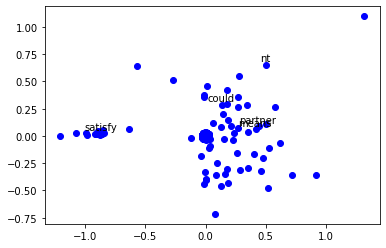

In [54]:
label = [w[0] for w in sorted(list(word_to_index.items())[:5], key=itemgetter(1))]
bengio.plot_words(label)

Calculamos la entropia

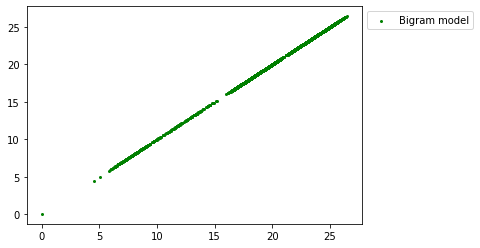

In [87]:
bengio.test2(train[:5])